In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.preprocessing import Imputer

import copy
import argparse

%matplotlib inline

In [2]:
ames_train = pd.read_csv('./datasets/train.csv')
ames_test = pd.read_csv('./datasets/test.csv')
ames_test_1 = pd.read_csv('./datasets/test.csv')
print(ames_train.shape)
print(ames_test.shape)

(2051, 81)
(879, 80)


In [3]:
ames_train['base_1st'] = ames_train['Total Bsmt SF'] * ames_train['1st Flr SF']
ames_test['base_1st'] = ames_test['Total Bsmt SF'] * ames_test['1st Flr SF']

In [4]:
ames_train['quality_year'] = ames_train['Overall Qual'] * ames_train['Year Built']
ames_test['quality_year'] = ames_test['Overall Qual'] * ames_test['Year Built']

In [5]:
ames_train['quality_sq_ft'] = ames_train['Overall Qual'] * ames_train['1st Flr SF']
ames_test['quality_sq_ft'] = ames_test['Overall Qual'] * ames_test['1st Flr SF']

In [6]:
# ames_train._get_numeric_data
ames_test.fillna(ames_test.mean(), inplace=True)
ames_test.fillna('no_value_reported', inplace=True)

In [7]:
ames_test.isnull().sum()

Id                0
PID               0
MS SubClass       0
MS Zoning         0
Lot Frontage      0
Lot Area          0
Street            0
Alley             0
Lot Shape         0
Land Contour      0
Utilities         0
Lot Config        0
Land Slope        0
Neighborhood      0
Condition 1       0
Condition 2       0
Bldg Type         0
House Style       0
Overall Qual      0
Overall Cond      0
Year Built        0
Year Remod/Add    0
Roof Style        0
Roof Matl         0
Exterior 1st      0
Exterior 2nd      0
Mas Vnr Type      0
Mas Vnr Area      0
Exter Qual        0
Exter Cond        0
                 ..
Kitchen AbvGr     0
Kitchen Qual      0
TotRms AbvGrd     0
Functional        0
Fireplaces        0
Fireplace Qu      0
Garage Type       0
Garage Yr Blt     0
Garage Finish     0
Garage Cars       0
Garage Area       0
Garage Qual       0
Garage Cond       0
Paved Drive       0
Wood Deck SF      0
Open Porch SF     0
Enclosed Porch    0
3Ssn Porch        0
Screen Porch      0


In [8]:
tested_col = ['Neighborhood',
            'Overall Qual',
            'Overall Cond', 
            'Year Built', 
            'Year Remod/Add', 
            'Total Bsmt SF', 
            '1st Flr SF',
            'Gr Liv Area',
            'Full Bath',
            'TotRms AbvGrd',
            'base_1st',
            'quality_year',
            'quality_sq_ft']

In [9]:
ames_train.corr()[['SalePrice']].sort_values('SalePrice', ascending=False)

SalePrice
SalePrice         1.000000
quality_year      0.806902
Overall Qual      0.800207
quality_sq_ft     0.792151
Gr Liv Area       0.697038
Garage Area       0.650270
Garage Cars       0.648220
Total Bsmt SF     0.628925
1st Flr SF        0.618486
Year Built        0.571849
Year Remod/Add    0.550370
base_1st          0.539397
Full Bath         0.537969
Garage Yr Blt     0.533922
Mas Vnr Area      0.512230
TotRms AbvGrd     0.504014
Fireplaces        0.471093
BsmtFin SF 1      0.423519
Lot Frontage      0.341842
Open Porch SF     0.333476
Wood Deck SF      0.326490
Lot Area          0.296566
Bsmt Full Bath    0.283662
Half Bath         0.283001
2nd Flr SF        0.248452
Bsmt Unf SF       0.190210
Bedroom AbvGr     0.137067
Screen Porch      0.134581
3Ssn Porch        0.048732
Mo Sold           0.032735
Pool Area         0.023106
BsmtFin SF 2      0.016255
Misc Val         -0.007375
Yr Sold          -0.015203
Low Qual Fin SF  -0.041594
Bsmt Half Bath   -0.045328
Id               -0.051398
MS SubClass      -0.087335
Overall Cond     -0.097019
Kitchen AbvGr    -0.125444
Enclosed Porch   -0.135656
PID              -0.255052

In [10]:
corr_1 = ames_train.corr()[['SalePrice', 
            'Overall Qual',
            'Overall Cond', 
            'Year Built', 
            'Year Remod/Add', 
            'Total Bsmt SF', 
            '1st Flr SF',
            'Gr Liv Area',
            'Full Bath',
            'TotRms AbvGrd',
            'base_1st',
            'quality_year',
            'quality_sq_ft']]
# ames_train.corr().shape
corr_1.shape

(42, 13)

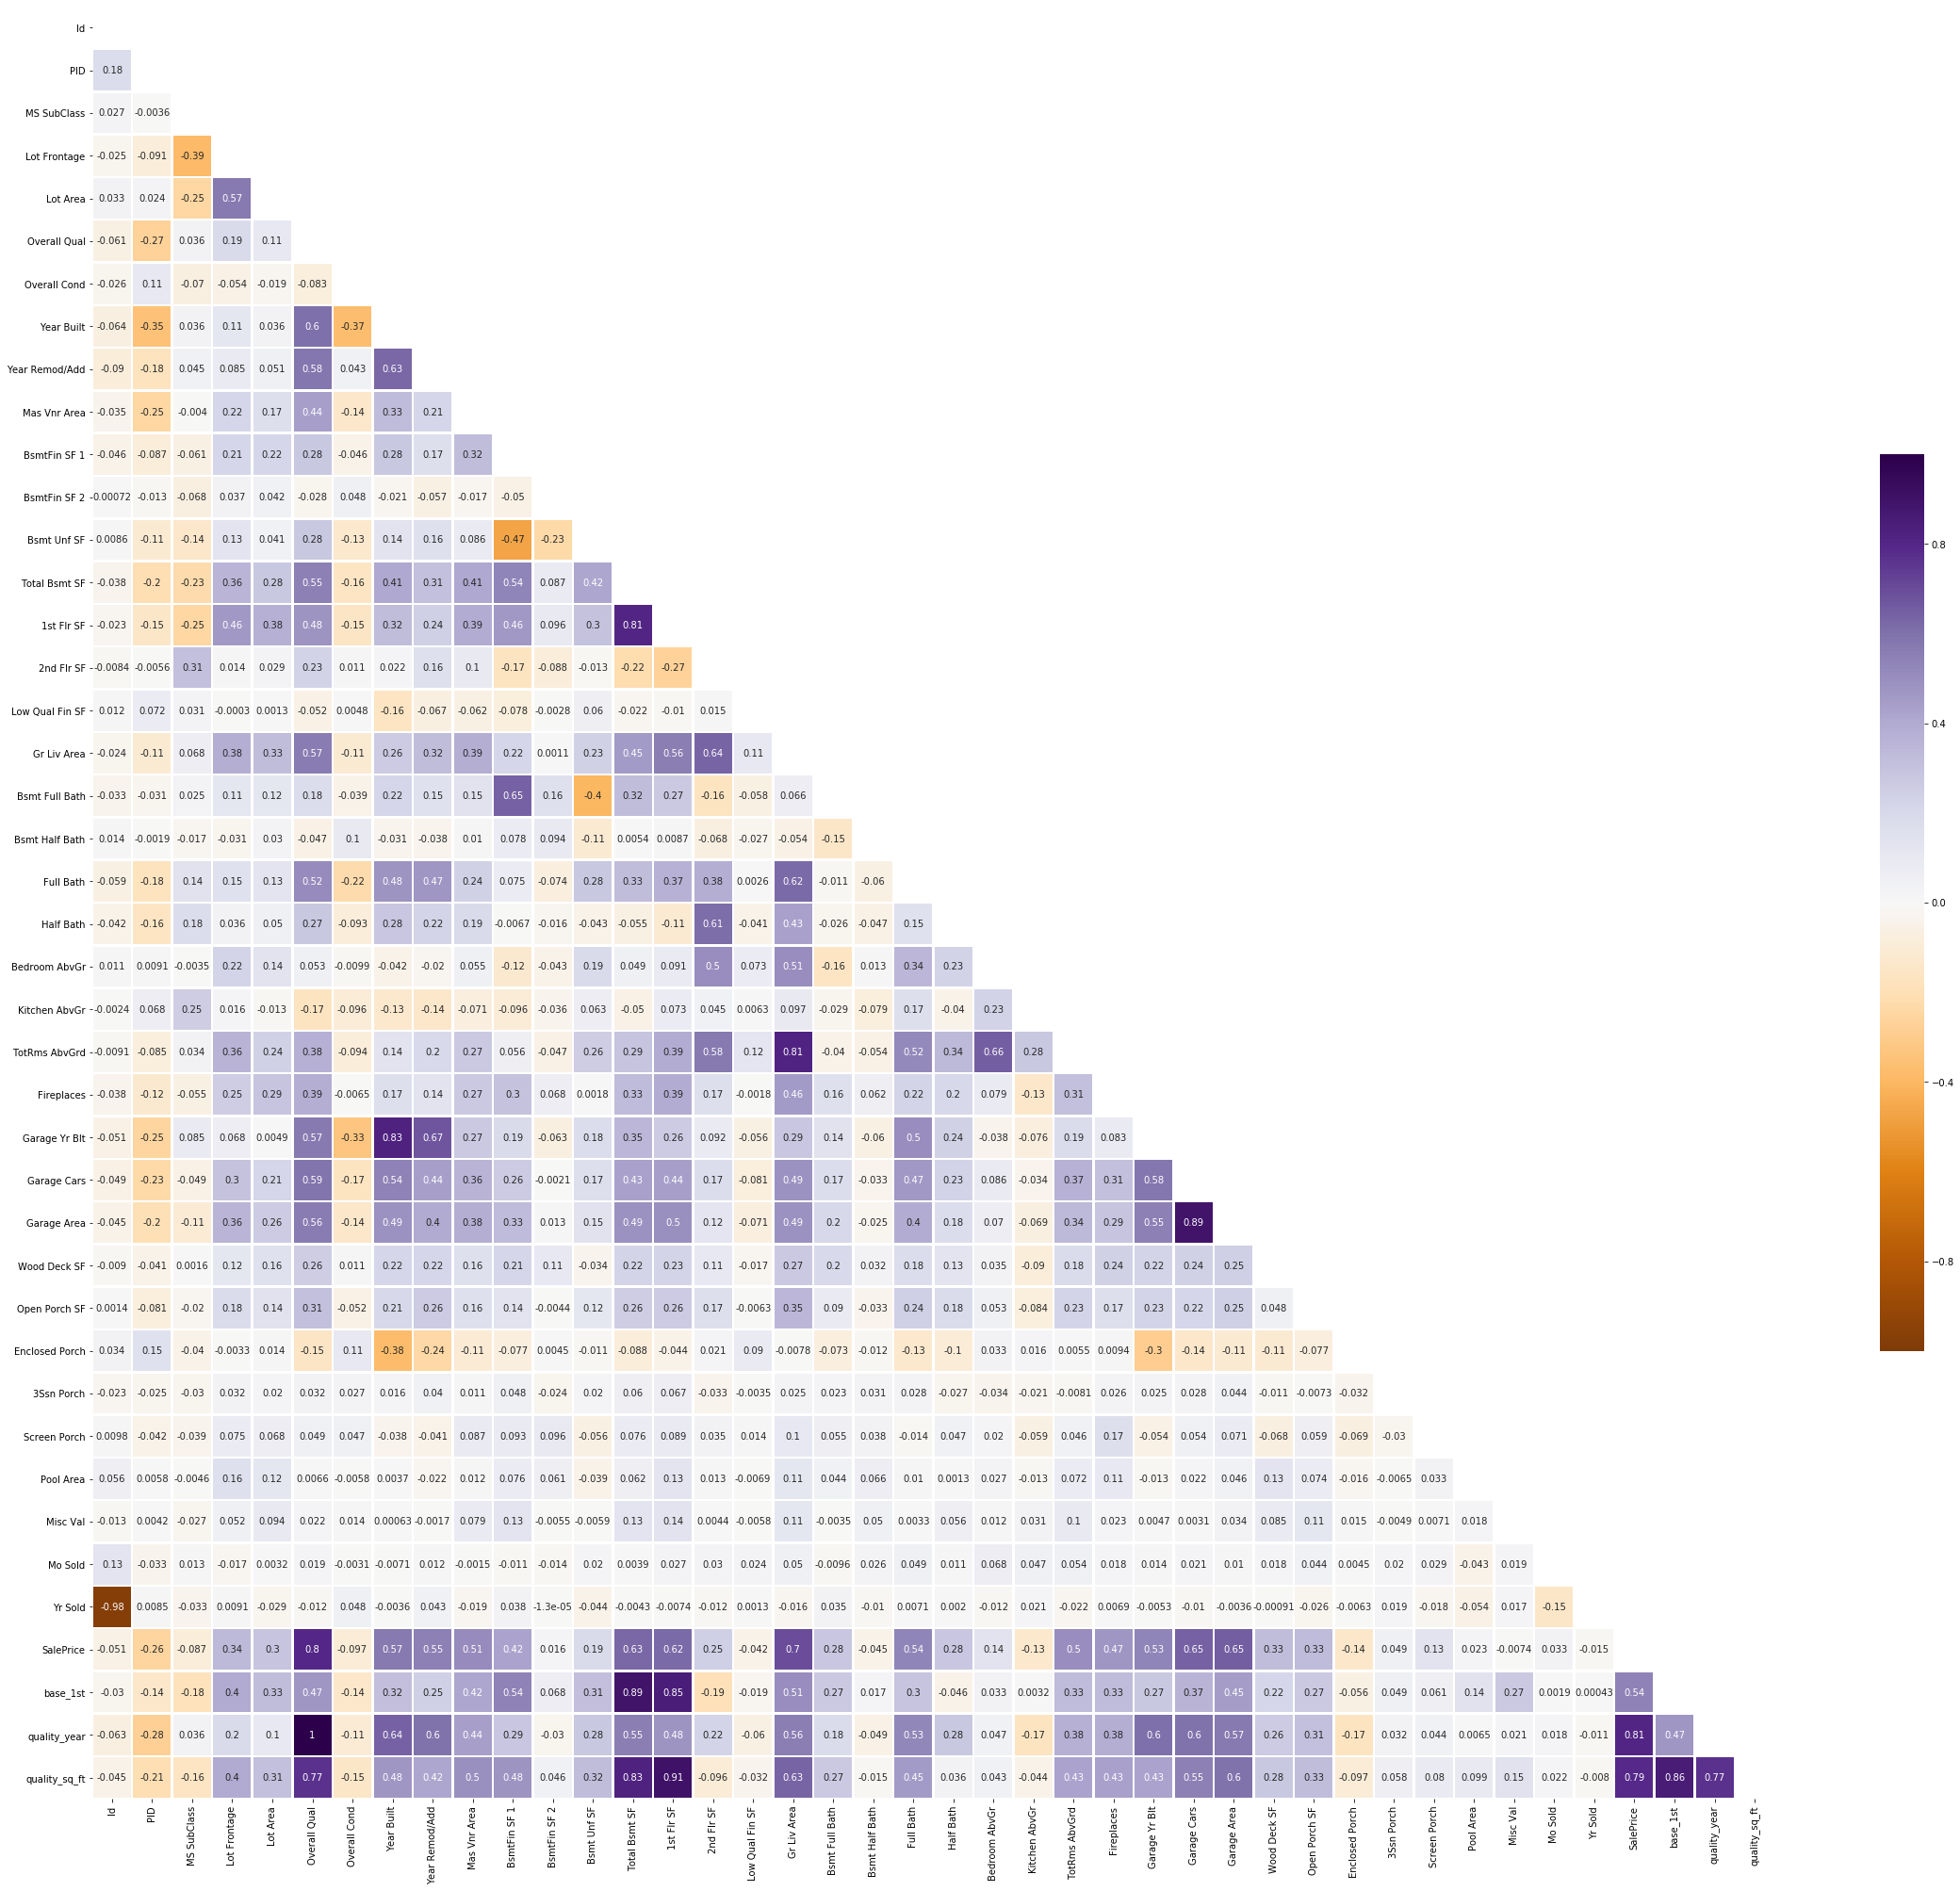

In [11]:
plt.figure(figsize = (40, 35))

mask = np.zeros_like(ames_train.corr())
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(ames_train.corr(), mask=mask, annot=True, cmap='PuOr', vmax=1, vmin=-1,
            square=False, linewidths=1.5,  cbar_kws={"shrink": .5})


In [12]:
# # Creating a function that makes a power variable (feature) and puts that feature in a dataframe.
# def new_variable(series_1, series_2, series_name, df):
#     df[series_name] = series_1 * series_2
#     return df

In [13]:
def dropped_cols(df, tested_col):
    dropped_col = []
    for col in df:
        if col not in tested_col:
            dropped_col.append(col)
    return dropped_col  


def dummy_vars_list(df, tested_cols):
    dummy_vars_list = []
    for col in tested_cols:
        if df[col].dtype.name == 'object':
            dummy_vars_list.append(col)
    return dummy_vars_list            
    


def get_dummies(train, test, columns, drop_first=True,
                inplace=False):
    if not inplace:
        train = copy.deepcopy(train)
        test = copy.deepcopy(test)
        

    for column in columns:
        train_levels = set(train[column])
        test_levels = set(test[column])
        all_levels = sorted(train_levels.union(test_levels))
        if drop_first:
            all_levels = all_levels[1:]
        for level in all_levels:
            dummy_name = "%s_is_%s" % (column, level)
            train[dummy_name] = (train[column] == level) # Could be replaced with an if statement
            test[dummy_name] = (test[column] == level)
    train.drop(columns=columns, inplace=True)
    test.drop(columns=columns, inplace=True)

    
    # return only necessary if inplace=False
    return (train, test)

def check_compatibility(train, test):
    # assume compatible unless one of these checks fails
    if not (len(train.columns) == len(test.columns)):
        return False
    for column in train.columns:
        if not (column in test.columns):
            return False
    return True


def clean_data(train, test, columns_to_drop,
               columns_for_dummies, remove_na=True,
               drop_first=True, inplace=False):
    if not inplace:
        train = copy.deepcopy(train)
        test = copy.deepcopy(test)
  
    # inplace=True because if user called with inplace=False,
    # we already made a copy and aren't modifying his/her original
    train.drop(columns=columns_to_drop, inplace=True)
    test.drop(columns=columns_to_drop, inplace=True)
  

#     same reason as above for inplace=True
    if remove_na:
        train.dropna(inplace=True)
        test.dropna(inplace=True)


    (train, test) = get_dummies(train, test,
                                columns=columns_for_dummies,
                                drop_first=drop_first,
                                inplace=inplace)
    

    return (train, test)


###################

def patrick_clean_data(train_df, test_df, variables, remove_na=True, drop_first=True, inplace=False):
    columns_to_drop = dropped_cols(test_df, variables)
    dummy_columns = dummy_vars_list(test_df, variables)
    new_train, new_test = clean_data(train_df, test_df, 
                                     columns_to_drop, 
                                     dummy_columns, 
                                     remove_na=remove_na, 
                                     drop_first=drop_first, 
                                     inplace=inplace)
    
    y_col_name = []
    for col in new_train.columns:
        if col not in new_test.columns:
            y = new_train[col]
            y_col_name = col
    new_train = new_train.drop(y_col_name, axis=1)
    
    assert check_compatibility(new_train, new_test)
    
#     for column in new_test.columns: # Turn this on if I want to see what columns were made
#         print(column)

    return new_train, new_test, y

In [14]:
new_train, new_test, y = patrick_clean_data(ames_train, ames_test, tested_col,)
print(new_test.shape)
print(new_train.shape)
print(y.shape)

(879, 39)
(2050, 39)
(2050,)


In [19]:
def metrics_summary(X, y, test_set, cv, k, scaled=True):
    ss = StandardScaler()
    ss.fit(X)
    X_sc = ss.transform(X)
    test_sc = ss.transform(test_set)
    model = LinearRegression()
    lasso = LassoCV(cv=5)    
    ridge = RidgeCV(cv=5)
    model.fit(X,y)
    model_p = model.predict(X)
    resids = y - model_p
    rss = (resids ** 2).sum()
    r_squared = (metrics.r2_score(y, model_p))
    adj_r2 = 1 - (1-r_squared)*((len(y)-1)/(len(y)-X.shape[k]-1))
    cvs = cross_val_score(model, X_sc, y, cv=cv).mean()
    cvs_l = cross_val_score(lasso, X_sc, y, cv=cv).mean()
    cvs_r = cross_val_score(ridge, X_sc, y, cv=cv).mean()

    print(f'RSS (Residual Sum of Squares) : {(rss)}')
    print(f'MAE (Mean Absolute Error) : {(metrics.mean_absolute_error(y, model_p))}') 
    print(f'MSE (Mean Square Error) : {(metrics.mean_squared_error(y, model_p))}')
    print(f'Root MSE (Root Meen Square Error) : {(np.sqrt(rss / len(model_p)))}')
    print(f'R\u00b2 : {(r_squared)}')
    print(f'Adjusted R\u00b2 : {(adj_r2)}')
    print(f'CVS (Cross Value Score LR) : {(cvs)}')
    print(f'CVS (Cross Value Score Lasso) : {(cvs_l)}')
    print(f'CVS (Cross Value Score Ridge) : {(cvs_r)}')
    
    model.fit(X_sc, y)
    model_pred = model.predict(test_sc)
    lasso.fit(X_sc, y)
    lasso_pred = lasso.predict(test_sc)
    ridge.fit(X_sc, y)
    ridge_pred = ridge.predict(test_sc)
    
    if cvs > cvs_l & cvs_r:
        prediction = pd.DataFrame(model_pred, columns=['SalePrice']).to_csv('wd_prediction_5.csv')
    elif cvs_l > cvs & cvs_r:
        prediction = pd.DataFrame(lasso_pred, columns=['SalePrice']).to_csv('wd_prediction_5.csv')
    elif cvs_r > cvs & cvs_l:
        prediction = pd.DataFrame(ridge_pred, columns=['SalePrice']).to_csv('wd_prediction_5.csv')
    return prediction


In [20]:
metrics_summary(new_train, y, new_test, 5, 1, scaled=True)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by StandardScaler.
  """


RSS (Residual Sum of Squares) : 1566379375797.9604
MAE (Mean Absolute Error) : 18721.96826541102
MSE (Mean Square Error) : 764087500.389249
Root MSE (Root Meen Square Error) : 27642.132703343443
R² : 0.8782681926419802
Adjusted R² : 0.8759062322007052
CVS (Cross Value Score LR) : -0.042991362171869184
CVS (Cross Value Score Lasso) : 0.8698255673197428
CVS (Cross Value Score Ridge) : 0.8713396127881328


TypeError: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
model = LinearRegression()
model.fit(new_train, y)
print(new_test.columns)
model_prediction = model.predict()

In [ ]:
model_prediction.shape

In [ ]:
prediction_1 = pd.DataFrame(model_prediction, columns=['SalePrice']).to_csv('wd_prediction_3.csv')


In [ ]:
# def dropped_cols(df, tested_col):
#     dropped_col = []
#     for col in df:
#         if col not in tested_col:
#             dropped_col.append(col)
#     return dropped_col  


# def dummy_vars_list(df, tested_cols):
#     dummy_vars_list = []
#     for col in tested_cols:
#         if df[col].dtype.name == 'object':
#             dummy_vars_list.append(col)
#     return dummy_vars_list            
    


# def get_dummies(train, test, columns, drop_first=True,
#                 inplace=False):
#     if not inplace:
#         train = copy.deepcopy(train)
#         test = copy.deepcopy(test)
        
#     print('******************************************************')
#     print(test)
#     print(train)

#     for column in columns:
#         train_levels = set(train[column])
#         test_levels = set(test[column])
#         all_levels = sorted(train_levels.union(test_levels))
#         if drop_first:
#             all_levels = all_levels[1:]
#         for level in all_levels:
#             dummy_name = "is_%s" % level
#             train[dummy_name] = (train[column] == level)
#             test[dummy_name] = (test[column] == level)
#             train[dummy_name].apply(int)
#             test[dummy_name].apply(int)
#     train.drop(columns=columns, inplace=True)
#     test.drop(columns=columns, inplace=True)

# #     print('******************************************************')
# #     print(test)
# #     print(train)
    
#     # return only necessary if inplace=False
#     return (train, test)

# def check_compatibility(train, test):
#     # assume compatible unless one of these checks fails
#     if not (len(train.columns) == len(test.columns)):
#         return False
#     for column in train.columns:
#         if not (column in test.columns):
#             return False
#     return True


# def clean_data(train, test, columns_to_drop,
#                columns_for_dummies, remove_na=True,
#                drop_first=True, inplace=False):
#     if not inplace:
#         train = copy.deepcopy(train)
#         test = copy.deepcopy(test)
  
#     # inplace=True because if user called with inplace=False,
#     # we already made a copy and aren't modifying his/her original
#     train.drop(columns=columns_to_drop, inplace=True)
#     test.drop(columns=columns_to_drop, inplace=True)
  

#     # same reason as above for inplace=True
#     if remove_na:
#         train.dropna(inplace=True)
#         test.fillna(0, axis=0, inplace=True)

# #     print(test)
# #     print(train)

#     (train, test) = get_dummies(train, test,
#                                 columns=columns_for_dummies,
#                                 drop_first=drop_first,
#                                 inplace=inplace)

#     return (train, test)


# ###################

# def patrick_clean_data(train_df, test_df, variables, remove_na=True, drop_first=True, inplace=False):
#     columns_to_drop = dropped_cols(test_df, variables)
#     dummy_columns = dummy_vars_list(test_df, variables)
#     new_train, new_test = clean_data(train_df, test_df, 
#                                      columns_to_drop, 
#                                      dummy_columns, 
#                                      remove_na=remove_na, 
#                                      drop_first=drop_first, 
#                                      inplace=inplace)
#     y_col_name = []
#     for col in new_train.columns:
#         if col not in new_test.columns:
#             y = new_train[col]
#             y_col_name = col
#     new_train = new_train.drop(y_col_name, axis=1)
    
#     assert check_compatibility(new_train, new_test)
    
# #     for column in new_test.columns: # Turn this on if I want to see what columns were made
# #         print(column)

#     return new_train, new_test, y